# Laboratory Work: Chickenpox Propagation Prediction/Forecasting
## Introduction
- The objective of this Laboratry Work is to put in application time series data forecasting using a **Deep Neural Network**. For that it is nececssary to learn the model behind the time series data giving the relation between output, input, and their past and future values as given in the relation below:
$$y(k+p)=F(y(k),y(k-1),\ldots,y(k-d_y), u(k),u(k-1),u(k-2),\ldots,u(k-d_u))$$
where:
    - $y(k)$: is the output predicted signal
    - $u(k)$: is the input signal
    - $p$: is the prediction order
    - $d_y$: is the output memory/delay order or output prediction horizon 
    - $d_u$: is the input memory/delay order  or input prediction horizon 
- In our application  $p>0$, $d_u=0$ and $d_y>0$
- We will resolve this prediction problem by transforming the related recurrent Neural Network to a feedforword Neural Network and using the learning algorithms and tools provided by Keras toolbox. So if we consider that we have a learning base given by $u(k), y(k), k=1,2,\ldots, n $ we have to create one input signal from input learning base $u(k)$ and $d_y+1$ input signal coming from shifted in the past $y(k)$ signal. We can begin the prediction learning with $p=1$ and $d_y=9$ as given in the construction of learning base in section *Data Base*.
- **Work to be done**:
    - For different perdiction horizont $p\in{1,2,3}$ and memory/predictor order $d_y\in{7,8,9,10}$ propose a Neural Network  architecture, operate the learning phase, give the results of testing phase and make some conclusions wrt accuracy.
    - **Optional**: Propose other Neuronal Network architecture like SimpleRNN, GRU or LSTM to implement and operate the learning and compare your results with the feedforward architecture given above.
    - **Optional**: Modify the layers and parameters,  build your own models for better MSE.
    - **Optional**: Propose an implementation of Back Propogation algorithm to operate the learning phase.
    - Genral conclusion
- **A report** on the Laboratory Work has to be written in **Jupyter** or in any other editor.
- **The report** as well as **Jupyter report and code** has to be uploaded to Blackboard  **before 14 of April 2024**  specifying the name of persons involved (**which has to be at maximun two**). The name of the persons involved has to be given in the report also.

In [178]:
import keras.src.layers
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from keras import models
from keras import layers
from keras import utils
from keras import optimizers
from sklearn.preprocessing import StandardScaler
import pandas as pd
from keras import Sequential, losses, metrics

## Load Dataset
- The example trains an **Deep neural Network** to forecast the number of chickenpox cases, taken from the data set **chickenpox_dataset**, given the number of cases in previous months
- Load the example data from **data_chickenpox.txt** text file which contains a single time series, with time steps corresponding to months and values corresponding to the number of cases 
- Construct the input **Deep Neural Network** input w.r.t memory/predictor horizon (**$nn_0$**) ( 10 in our case)
- Split the data in **Training Set**, **Validation Set** and **Test Set**
- $nn_0$ gives the output prediction horizon or number of neurons in the input layer
- $nn_1$ gives the number of neurons in the hidden layer
- $nn_2$ gives the number of neurons in the output layer     

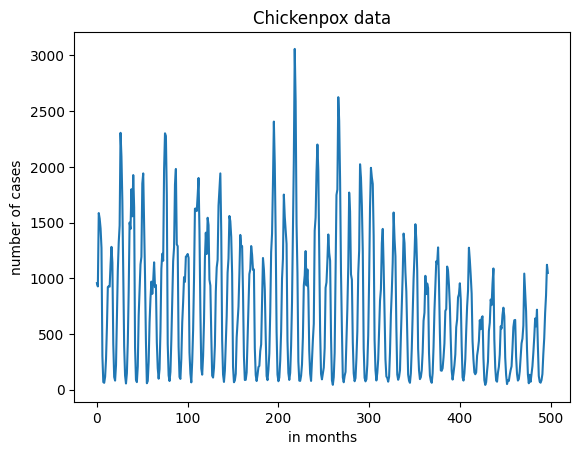

(498,)
(490, 8)
(490, 1)


In [179]:
S= np.loadtxt('data_chickenpox.txt')
n=len(S)
plt.plot(S)
plt.title('Chickenpox data')
plt.xlabel('in months')
plt.ylabel('number of cases')
plt.show()
nn_0=9                                                                       # Prediction order or number of neurons in the input layer
nn_1=10                                                                       # Number of neurons in the hidden layer
nn_2=1                                                                        # Number of neurons in the output layer     
y=S
print(S.shape)
# Input Signal Contruction

p=1                                                             # l'horizon de prédiction
dy=7                                                            # la mémoire de sortie / l'ordre de retard
nn_0=dy+1                                                       # nombre de neurones dans la couche d'entrée
nn_1=10                                                         # Nombre de neurones dans la couche cachée
nn_2=1                                                          # Nombre de neurones dans la couche de sortie   
y=S

# Input Signal Contruction

V=y[dy:len(y)-p,]
for i in range(1, dy+1):
    V=np.c_[V,y[dy-i:len(y)-p-i,]]   

T=np.mat(y[dy+p:len(y),]).T                                   # Target Signal Contruction  # 目标信号的构建 
print(V.shape)
print(T.shape)
input_NN=V[:320,:]
target_NN=T[:320,]
input_validation = V[320:400,:] # We choose 20% of the training set data as the validation set
target_validation= T[320:400,]
input_Test=V[400:,:]
target_Test=T[400:,]


## Standardize Data
For a better fit and to prevent the training from diverging, standardize the training data to have zero mean and unit variance. Standardize the test data using the same parameters as the training data.

In [180]:
# Creating a Standard Scaler from sklearn: Null Mean and Unit Variance
scaler = StandardScaler()
input_NN = scaler.fit_transform(input_NN)
input_Test = scaler.transform(input_Test)
input_validation = scaler.transform(input_validation)

# Approximately 0
print(np.mean(input_NN))
print(np.mean(input_Test))
print(np.mean(input_validation))

# Approximately 1
print(np.var(input_NN))
print(np.var(input_Test))
print(np.var(input_validation))

# Target scaler
scaler_target = StandardScaler()

# Necessary for scaling
target_NN = np.asarray(target_NN)
target_Test = np.asarray(target_Test)
target_validation = np.asarray(target_validation)

# Same thing for the outputs
target_NN = scaler_target.fit_transform(target_NN)
target_Test = scaler_target.transform(target_Test)
target_validation = scaler_target.transform(target_validation)

8.326672684688674e-18
-0.6814701030390358
-0.35744048001643774
1.0000000000000007
0.21985047364098623
0.4426116537538093


## Deep Neural Network Architecture
### Linear Model
A linear layer, also known as a fully connected layer, performs a linear transformation to its input.
$$y=Wx+b$$
Where:

- $\textbf{y}$ is the output,
- $\textbf{W}$ is the weight matrix,
- $\textbf{x}$ is the input vector,
- $\textbf{b}$ is the bias vector.

**Implementation**:
- Define the type of DNN: In our case we have chosen the **Sequential** DNN
- Define the type of activation function for each layer (**linear,relu,linear** in our case)
- Define the learning/optimization method used (**RMSprop** in our case)
- Define the criteria to minimize and the related metric (**MSE** and **'MAE'** in our case)
- Define the **batch size** and the number of **epochs** (**batch_size=4, epochs=50** in our case)
- $nn_0$ gives the prediction horizon or number of neurons in the input layer
- $nn_1$ gives the number of neurons in the hidden layer
- $nn_2$ gives the number of neurons in the output layer     

In [181]:
# Creation of the model architecture, linear, relu and linear as given in the instructions above
model = models.Sequential([
    layers.Dense(nn_0, activation='linear'),
    layers.Dense(nn_1, activation='relu'),
    layers.Dense(nn_2, activation='linear'),
])

# Compile the model with the specified optimizer, loss, and metrics
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError()]
)

# Training the model with the data on 50 epochs with batches of 4.
model.fit(
    x=input_NN,
    y=target_NN,
    epochs=50,
    batch_size=4,
    validation_data=(input_validation, target_validation),
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4545 - mean_absolute_error: 0.9532 - val_loss: 0.3625 - val_mean_absolute_error: 0.4897
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.4156 - mean_absolute_error: 0.5113 - val_loss: 0.1879 - val_mean_absolute_error: 0.3467
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.1670 - mean_absolute_error: 0.3216 - val_loss: 0.1092 - val_mean_absolute_error: 0.2522
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.1296 - mean_absolute_error: 0.2826 - val_loss: 0.0896 - val_mean_absolute_error: 0.2244
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.1327 - mean_absolute_error: 0.2818 - val_loss: 0.0876 - val_mean_absolute_error: 0.2256
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.1356 - mean_absolute_error: 0.2846 - val_loss: 0.0643 - val_mean_absolute_error: 0.1945
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.1346 - mean_absolute_error: 0.2873 - val

## Experiments
The experiments examine the performance of Neural Net work performance for given combinason of *p* and *dy*.

**Implementations**:
The recommandated functions for this experiments are
- def **prepare_dataset** which splits the dataset into train and test set of data and labels and then returns them
- def **build_model** which returns a model for a given memory order *dy*
- def **expriments** which run experiments on a given model for the Cartean product on the memory order *dy* and the prediction horizon *p*
- def **plot_train_val_loss** which plot the history of training and validation(test) loss of each *dy* and *p*.
- def **plot_mse_table** which plot the validation(test) MSE of each *dy* and *p*.

In [190]:
def prepare_dataset(data, d_y, p, train_ratio=0.8):
    data_x, data_y = [], []
    
    # We iterate over the data to re-arrange it according to d_y and p.
    # Each slice of x1 to x2 will be associated to data[x2 + d_y + p]
    for i in range(d_y, len(data) - p):
        data_x.append(data[i - d_y:i])
        data_y.append(data[i+p])

    data_x, data_y = np.array(data_x), np.array(data_y)
        
    idx = int(len(data_x) * train_ratio)
    return (data_x[:idx], data_y[:idx]), (data_x[idx:], data_y[idx:])

In [196]:
def build_model(d_y, model_layers):
    # Creation of the model architecture, linear, relu and linear as given in the instructions above
    model = models.Sequential()
    model.add(layers.Input(shape=(d_y, 1)))
    for layer in model_layers:
        model.add(layer)
    
    # Compiling the model with the RMSProp optimizer, the Mean Squared Error loss function and the Mean Absolute error metric
    model.compile(
        optimizer=optimizers.RMSprop(),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanAbsoluteError()]
    )
    
    return model

In [209]:
def experiments(dataset, model_layers, max_dy_values=4, max_p_values=4, epochs=50, batch_size=4):
    results = {}
    
    # We iterate over all d_y and p values
    for d_y in range(1, max_dy_values):
        for p in range(1, max_p_values):
            # We build the dataset according to the current d_y and p values
            (train, test) = prepare_dataset(dataset, d_y, p)
            idx = int(len(train[0]) * 0.2)
            (valid, train) = (train[0][:idx], train[1][:idx]), (train[0][idx:], train[1][idx:])
        
            # We need to make sure that the data is standardized
            scaler = StandardScaler()
            scaler_target = StandardScaler()

            train = (scaler.fit_transform(train[0]), scaler_target.fit_transform(np.asarray(train[1]).reshape(-1, 1)))
            test = (scaler.transform(test[0]), scaler_target.transform(np.asarray(test[1]).reshape(-1, 1)))
            valid = (scaler.transform(valid[0]), scaler_target.transform(np.asarray(valid[1]).reshape(-1, 1)))
        
            # We build the model according to the current d_y and p values
            model = build_model(d_y, model_layers)
            
            # Training of the model for the current d_y and p
            history = model.fit(
                x=train[0],
                y=train[1],
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(valid[0], valid[1]),
                verbose=0
            )
            
            # Evaluating the model for the current d_y and p
            loss = model.evaluate(test[0], test[1], verbose=0)
            
            # We add the results to the returned variable
            results[(d_y, p)] = {'history': history.history, 'loss': loss}
            
    return results

In [210]:
def plot_train_val_loss(results):
    for (d_y, p), result in results.items():
        history = result['history']
        plt.figure()
        plt.plot(history['loss'], label='train_loss')
        plt.plot(history['val_loss'], label='val_loss')
        plt.title(f'Training and Validation Loss (d_y={d_y}, p={p})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [211]:
def plot_mse_table(results):
    mse_table = pd.DataFrame()
    for (d_y, p), result in results.items():
        mse = result['loss'][0]
        mse_table.loc[d_y, p] = mse
    print(mse_table.to_markdown())

|    |        1 |        2 |        3 |
|---:|---------:|---------:|---------:|
|  1 | 0.303216 | 0.630696 | 0.995851 |
|  2 | 0.502488 | 0.872117 | 1.13373  |
|  3 | 0.655943 | 0.972232 | 1.14696  |


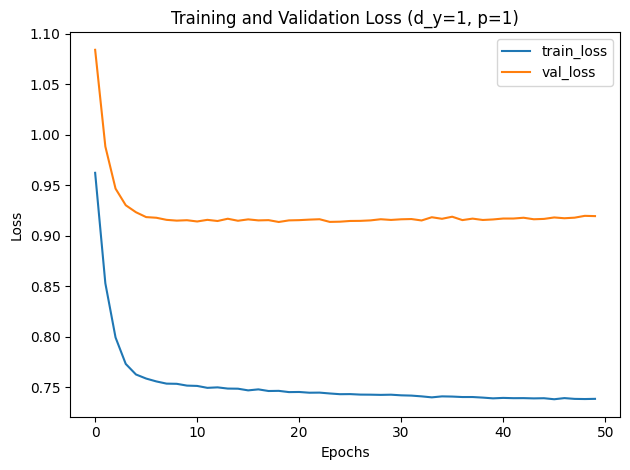

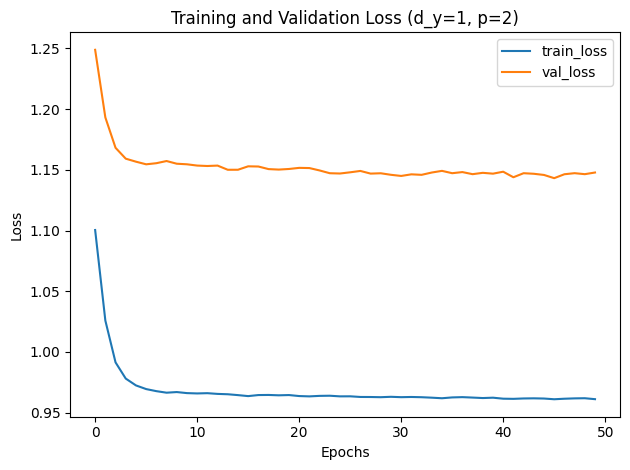

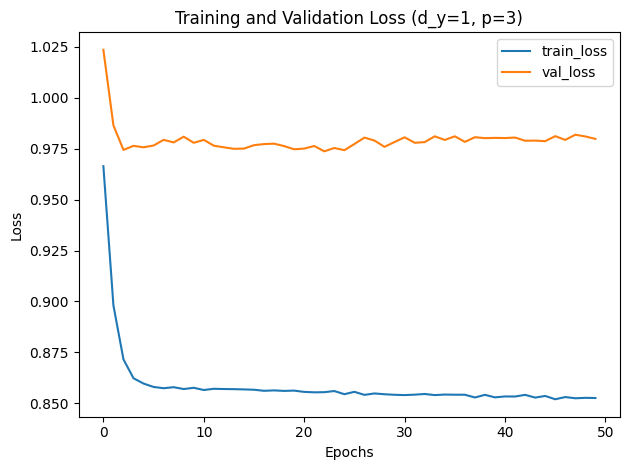

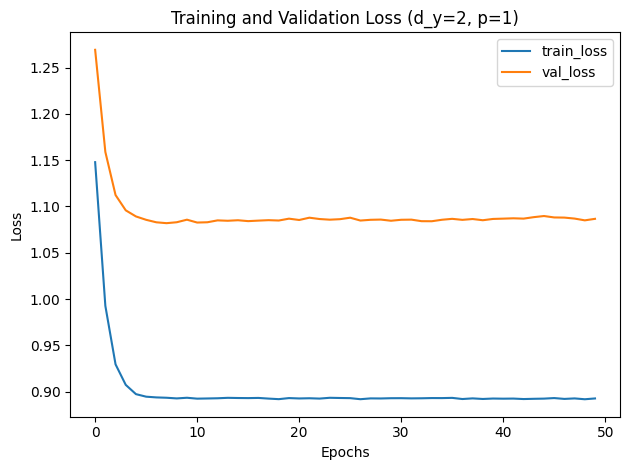

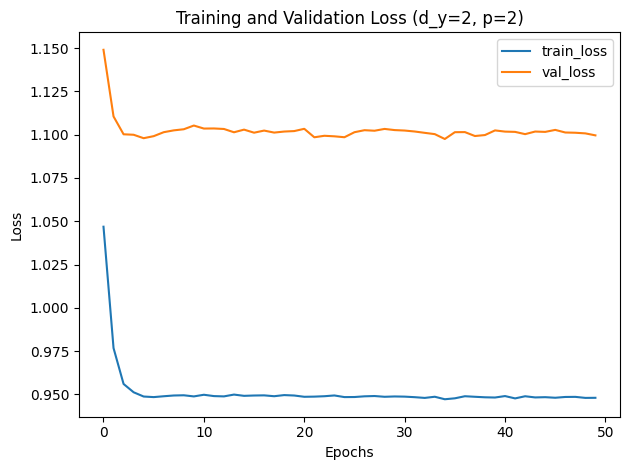

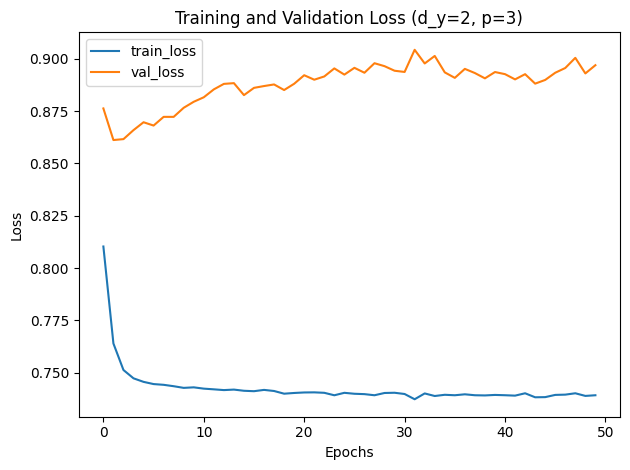

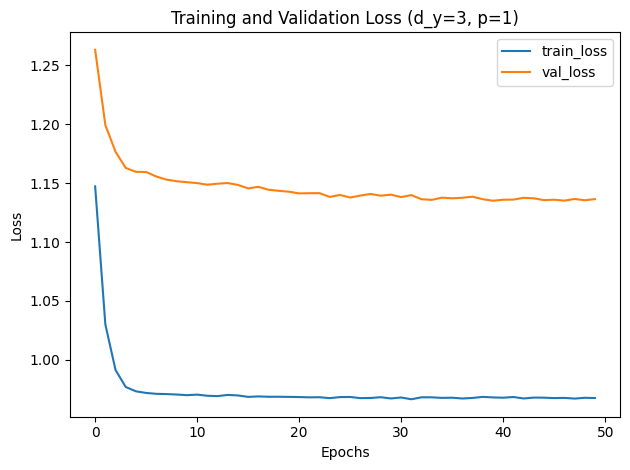

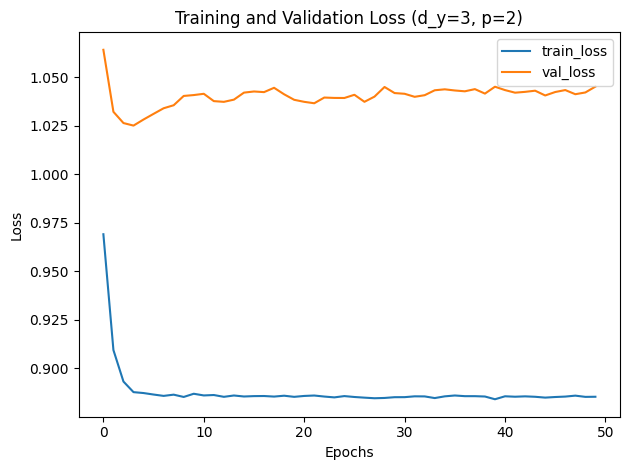

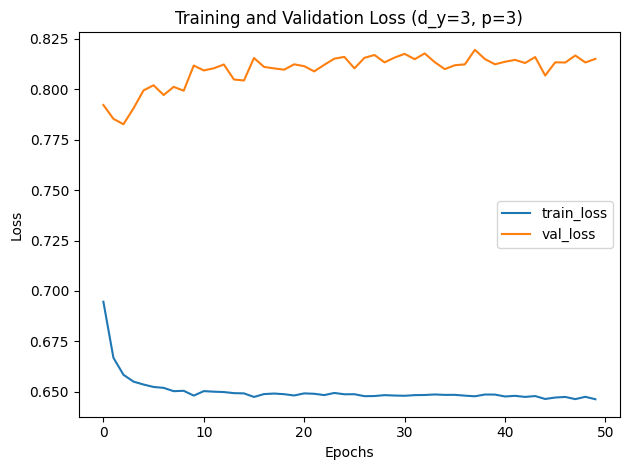

In [212]:
# Testing our functions
data = np.loadtxt('data_chickenpox.txt')

model_layers = [
    layers.Dense(activation='relu', units=10),
    layers.Dense(activation='linear', units=1)
]

results = experiments(data, model_layers)
plot_mse_table(results)
plot_train_val_loss(results)

## Experiments with Recurrent Models
In this section, we examine the prediction performance with recurrent models such as RNN, LSTM, GRU. It is recommanded to reuse previous code for experiments and plots.

Recurrent neural networks (RNNs) process data sequentially, using their hidden state to maintain a form of memory about previous inputs, allowing them to capture temporal dynamics and dependencies in sequential data. During backpropagation, RNNs use a technique called Backpropagation Through Time (BPTT), where gradients are computed for each time step in the sequence and then aggregated to update the weights, considering the contributions of each time step to the final output. However, BPTT can lead to challenges such as exploding or vanishing gradients due to the repeated multiplication of gradients through the sequence, affecting the network's ability to learn long-term dependencies.

Refs : https://www.youtube.com/watch?v=64Yl3K-4FzM&t=770s

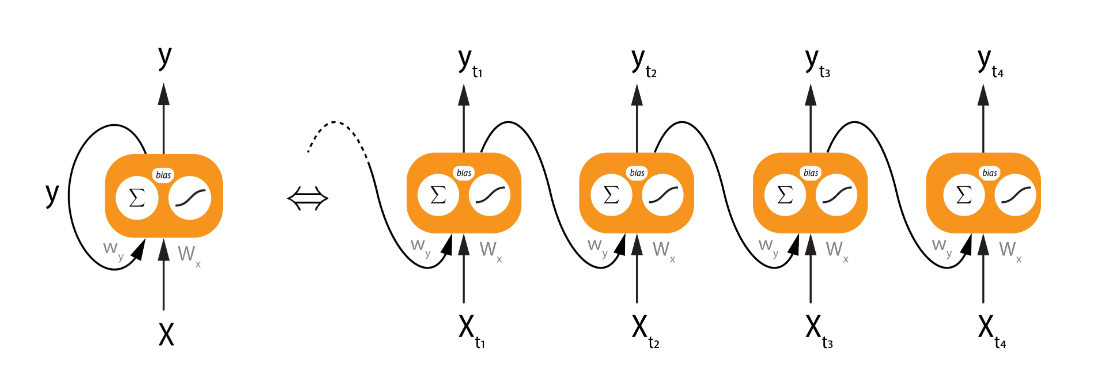


### Recurrent Neural Network (RNN)
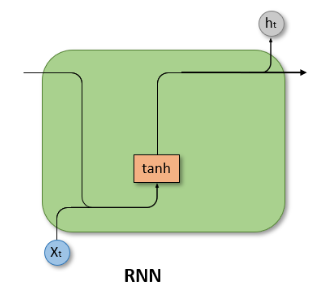

The basic recurrent neural network unit updates its hidden state ($h_t$) at each time step $t$ based on the previous hidden state ($h_{t-1}$) and the current input ($x_t$).

$$h_t =tanh(W_{hh} h_{t−1} +W_{xh}​ x_t​ +b_h )$$

Where:

- $h_t$ is the hidden state at time $t$,
- $\textbf{W}_{hh}$ is the weight matrix for the hidden state,
- $\textbf{W}_{xh}$ is the weight matrix for the input,
- $b_h$ is the bias,
- $\tanh$ is the hyperbolic tangent activation function.

In [213]:
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN

In [214]:
def experiments_rnn(dataset, model_layers, max_dy_values=4, max_p_values=4, epochs=50, batch_size=4):
    results = {}
    
    # We iterate over all d_y and p values
    for d_y in range(1, max_dy_values):
        for p in range(1, max_p_values):
            # We build the dataset according to the current d_y and p values
            (train, test) = prepare_dataset(dataset, d_y, p)
            idx = int(len(train[0]) * 0.2)
            (valid, train) = (train[0][:idx], train[1][:idx]), (train[0][idx:], train[1][idx:])

            # We need to make sure that the data is standardized
            scaler = StandardScaler()
            scaler_target = StandardScaler()
            
            train = (scaler.fit_transform(train[0]), scaler_target.fit_transform(np.asarray(train[1]).reshape(-1, 1)))
            test = (scaler.transform(test[0]), scaler_target.transform(np.asarray(test[1]).reshape(-1, 1)))
            valid = (scaler.transform(valid[0]), scaler_target.transform(np.asarray(valid[1]).reshape(-1, 1)))
          
            # We build the model according to the current d_y and p values
            model = build_model(d_y, model_layers)
            
            # Training of the model for the current d_y and p
            history = model.fit(
                x=train[0],
                y=train[1],
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(valid[0], valid[1]),
                verbose=0
            )
            
            # Evaluating the model for the current d_y and p
            loss = model.evaluate(test[0], test[1], verbose=0)
            
            # We add the results to the returned variable
            results[(d_y, p)] = {'history': history.history, 'loss': loss}
            
    return results

|    |        1 |        2 |        3 |
|---:|---------:|---------:|---------:|
|  1 | 0.300394 | 0.607792 | 0.982075 |
|  2 | 0.268397 | 0.62718  | 0.854978 |
|  3 | 0.278328 | 0.498175 | 0.755476 |


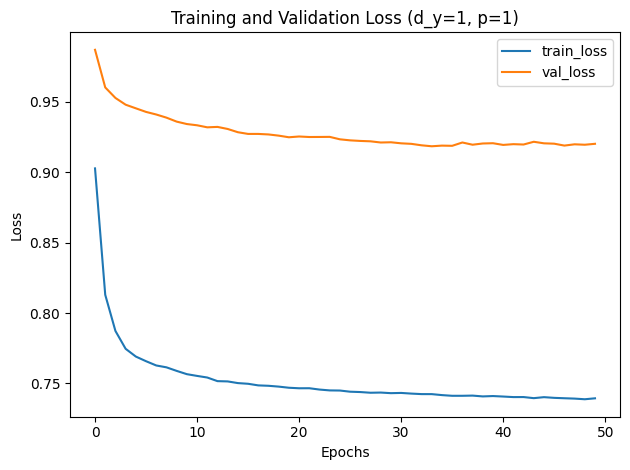

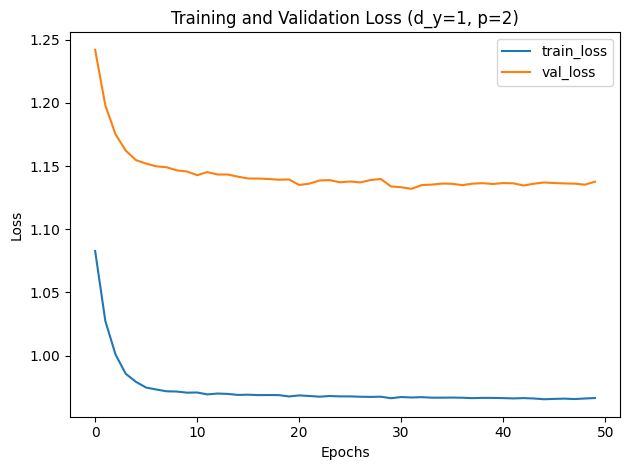

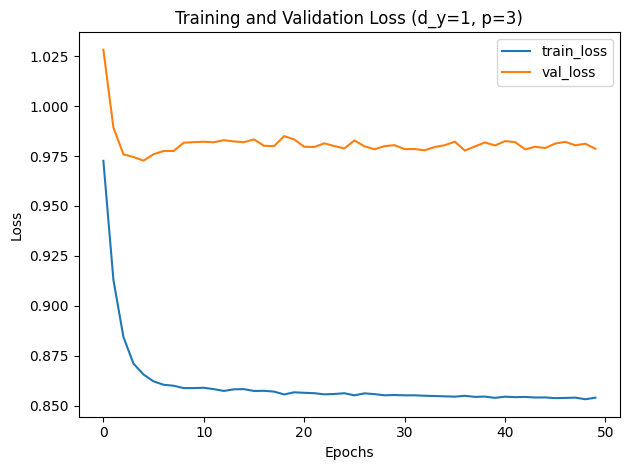

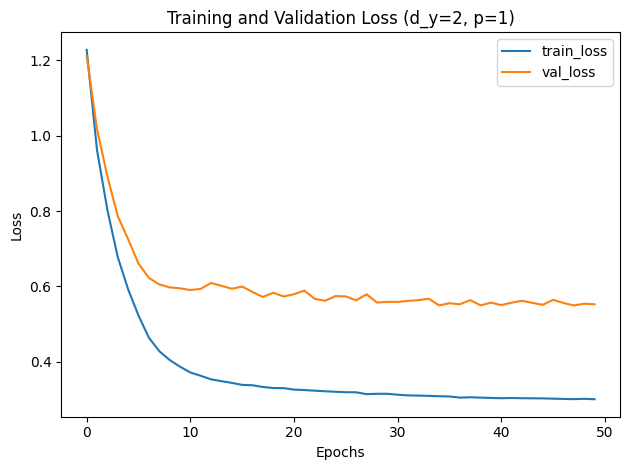

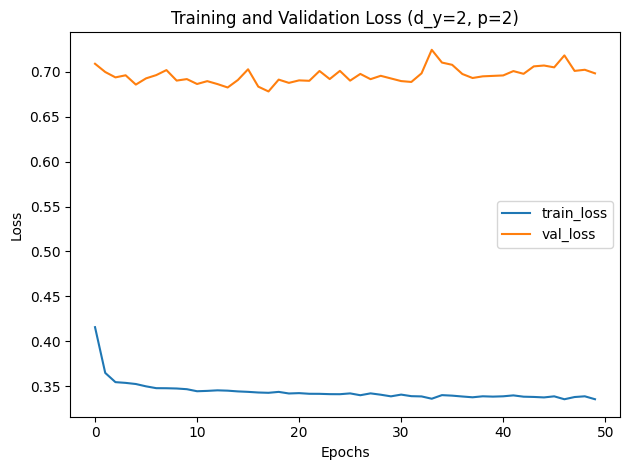

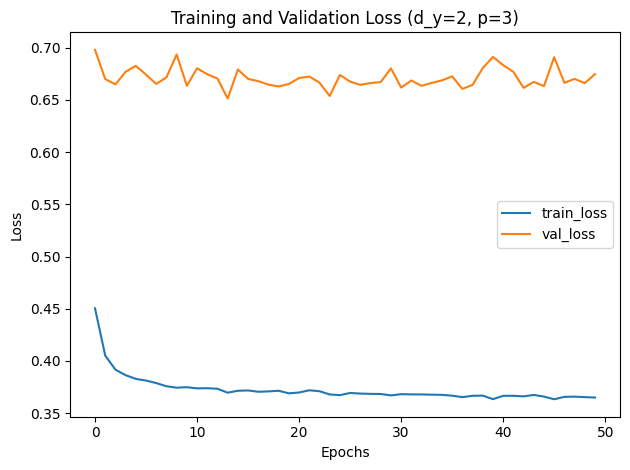

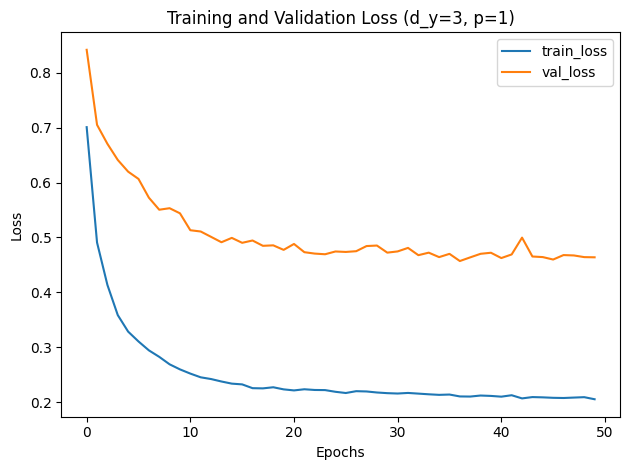

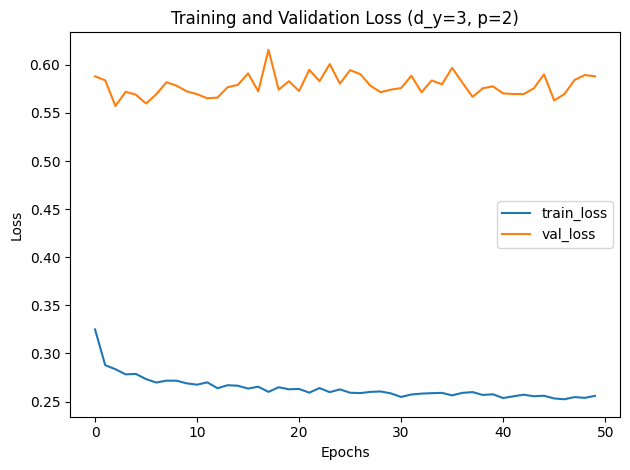

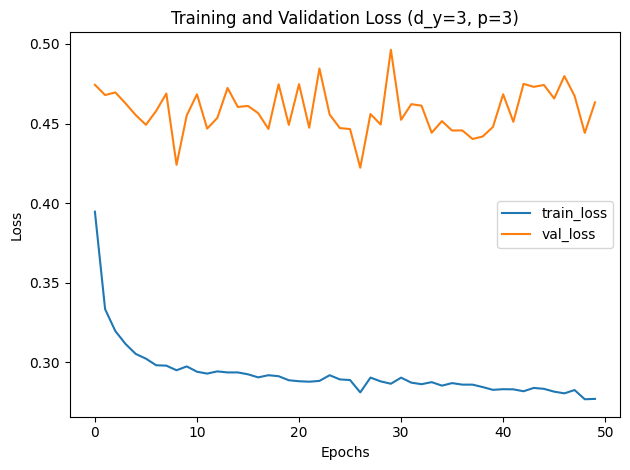

In [215]:
# Testing our functions
model_layers = [
    layers.SimpleRNN(activation='relu', units=10),
    layers.Dense(activation='linear', units=1),
]

results_rnn = experiments_rnn(data, model_layers)
plot_mse_table(results_rnn)
plot_train_val_loss(results_rnn)

### Long Short-Term Memory (LSTM)
Long Short-Term Memory (LSTM) networks is designed to overcome the limitations of RNNs, particularly their difficulty in learning long-term dependencies due to the vanishing and exploding gradient problem. LSTMs introduce a more complex architecture with input, output, and forget gates, allowing for selective remembering and forgetting of information, thus enabling the model to maintain information over longer sequences. 

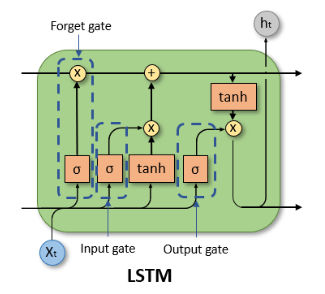

LSTM units include an input gate ($i_t$), a forget gate ($f_t$), an output gate ($o_t$), a activated cell state ($\tilde{c}_t$), and cell state ($c_t$)   to better capture long-term dependencies.

\begin{align*}
f_t &= \sigma(\textbf{W}_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(\textbf{W}_i \cdot [h_{t-1}, x_t] + b_i) \\
o_t &= \sigma(\textbf{W}_o \cdot [h_{t-1}, x_t] + b_o) \\
\tilde{c}_t &= \tanh(\textbf{W}_c \cdot [h_{t-1}, x_t] + b_c) \\
c_t &= f_t * c_{t-1} + i_t * \tilde{c}_t \\
h_t &= o_t * \tanh(c_t)
\end{align*}

Where:

- $\sigma$ is the sigmoid function,
- $*$ denotes element-wise multiplication (Hadamard product),
- $\textbf{W}$ and $b$ are the weight matrices and bias vectors for the gates.

|    |        1 |        2 |        3 |
|---:|---------:|---------:|---------:|
|  1 | 0.309068 | 0.547067 | 0.804542 |
|  2 | 0.277233 | 0.644368 | 1.08669  |
|  3 | 0.294593 | 0.574351 | 0.69705  |


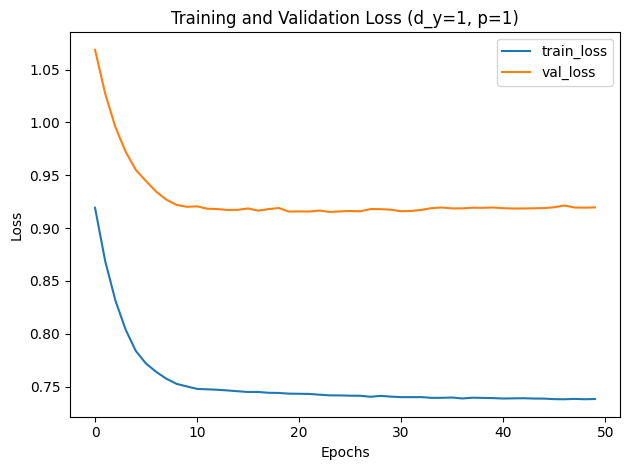

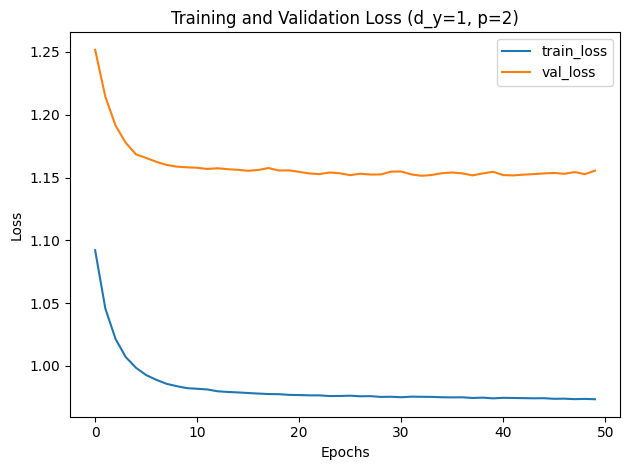

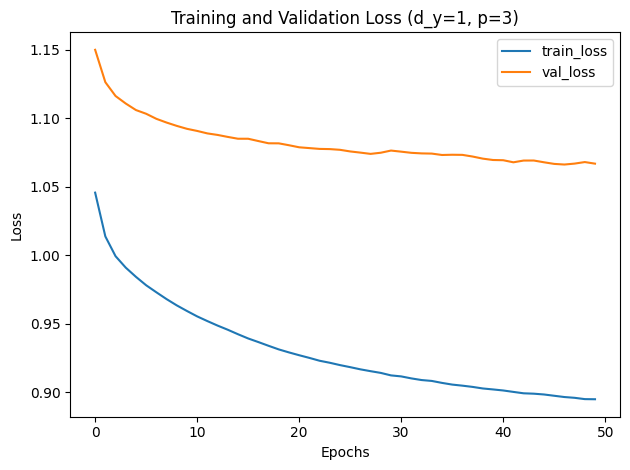

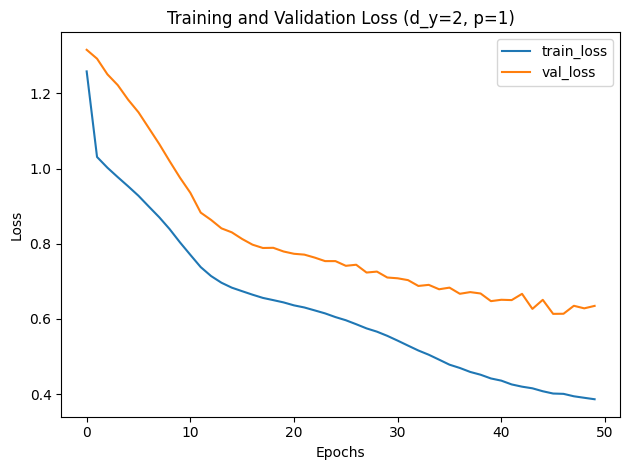

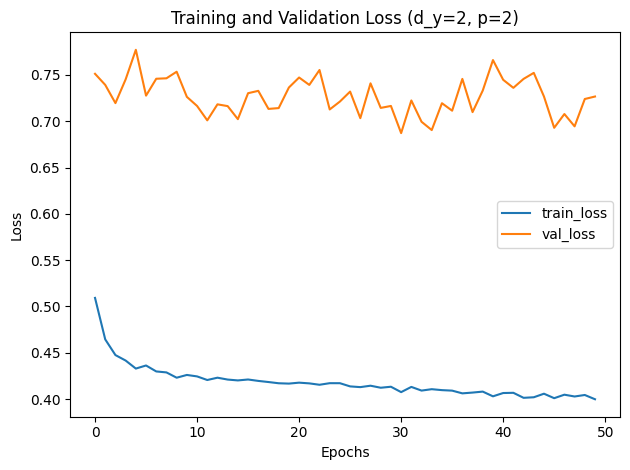

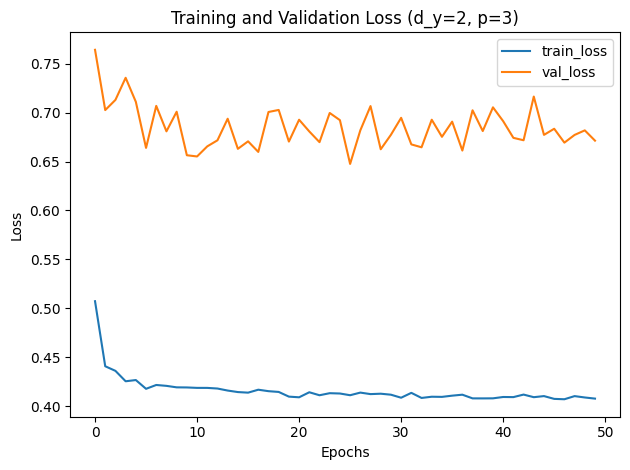

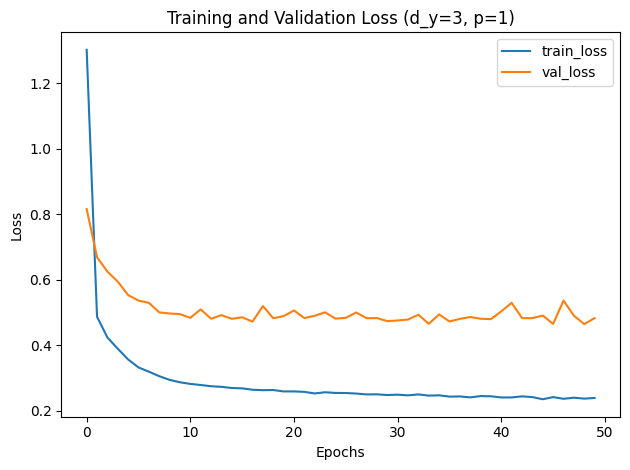

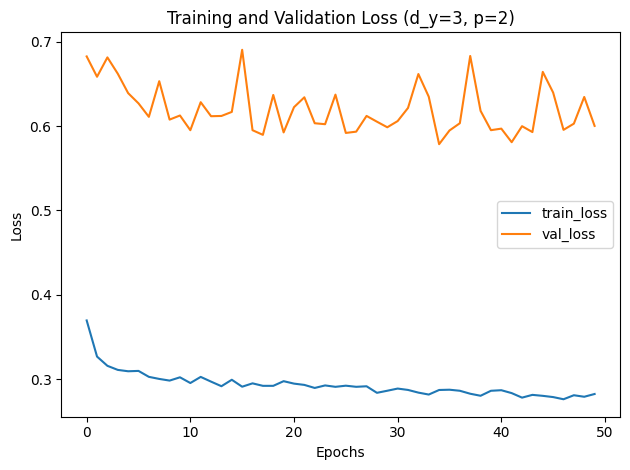

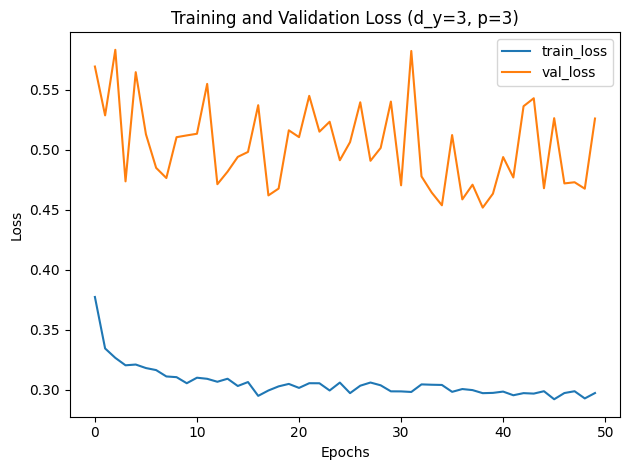

In [216]:
# Testing our functions
model_layers = [
    layers.LSTM(activation='relu', units=10),
    layers.Dense(activation='linear', units=1),
]

results_lstm = experiments_rnn(data, model_layers)
plot_mse_table(results_lstm)
plot_train_val_loss(results_lstm)

### Gated Recurrent Unit (GRU)
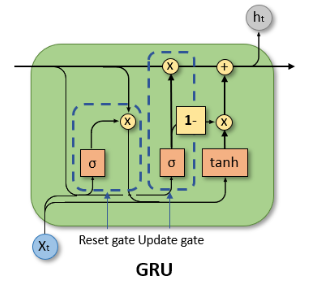

GRU simplifies the LSTM architecture by combining the forget and input gates into an reset gate ($r_t$) and also merging the cell state and hidden state. The update gate ($z_t$) in GRU is equivelent to the output gate in LSTM .

\begin{align*}
z_t &= \sigma(\textbf{W}z \cdot [h_{t-1}, x_t] + b_z) \\
r_t &= \sigma(\textbf{W}r \cdot [h_{t-1}, x_t] + b_r) \\
\tilde{h}_t &= \tanh(\textbf{W}_{n} \cdot [r_t * h_{t-1}, x_t] + b_{in} + r_t * b_{hn}) \\
h_t &= (1 - z_t) * \tilde{h}_t + z_t * h_{t-1}
\end{align*}

Where:

- $z_t$ is the update gate,
- $r_t$ is the reset gate,
- $\tilde{h}_t$ is the candidate activation (new gate),
- $\textbf{W}$ and $b$ are the weight matrices and bias vectors for the gates.

|    |        1 |        2 |        3 |
|---:|---------:|---------:|---------:|
|  1 | 0.339904 | 0.539959 | 0.605513 |
|  2 | 0.262316 | 0.59537  | 0.988494 |
|  3 | 0.344406 | 0.62785  | 1.0002   |


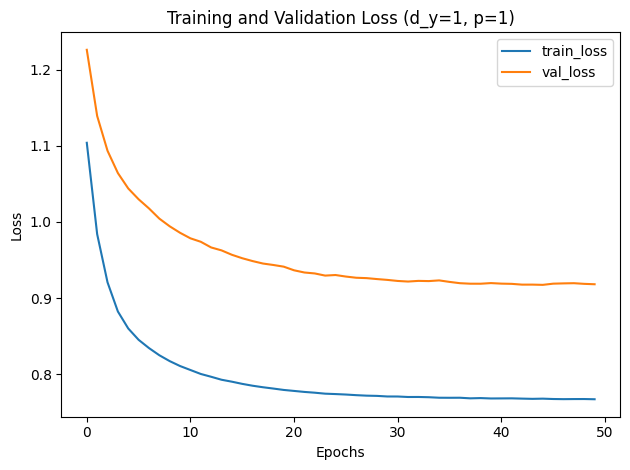

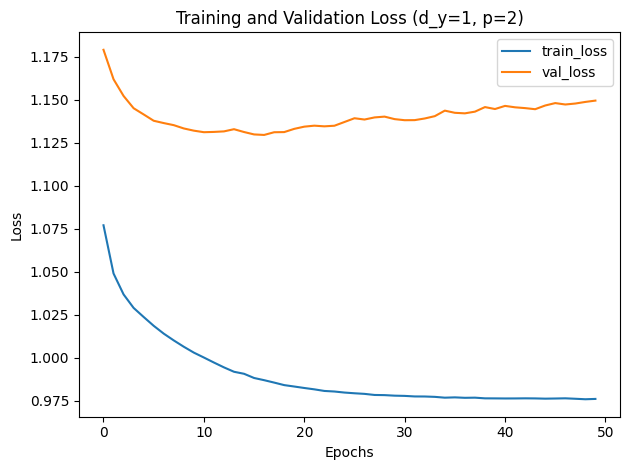

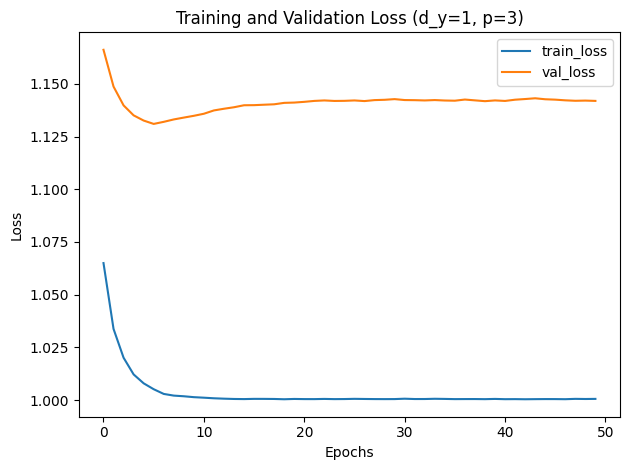

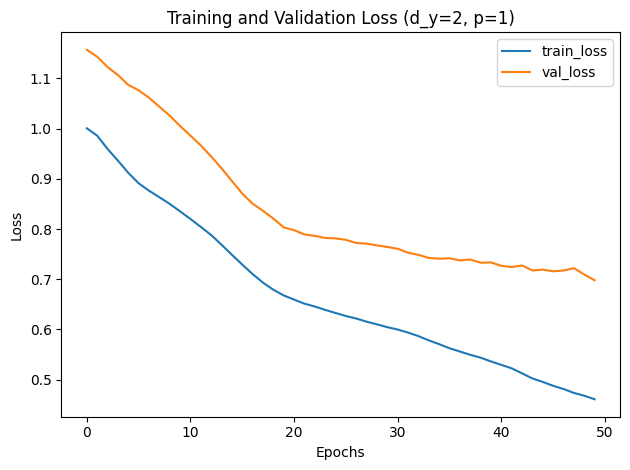

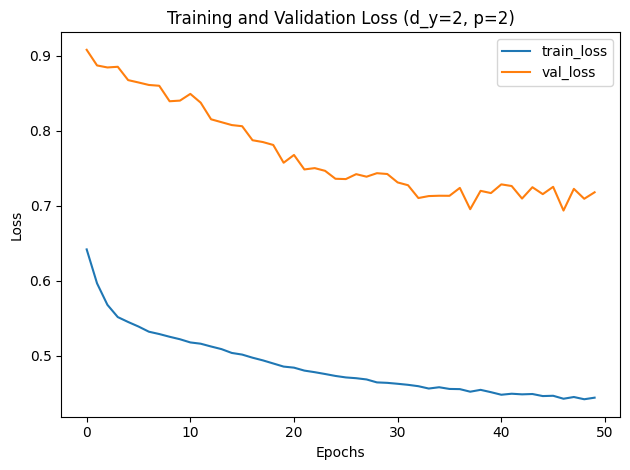

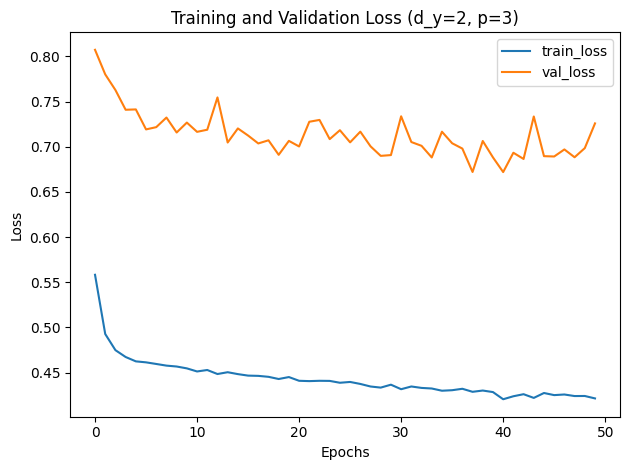

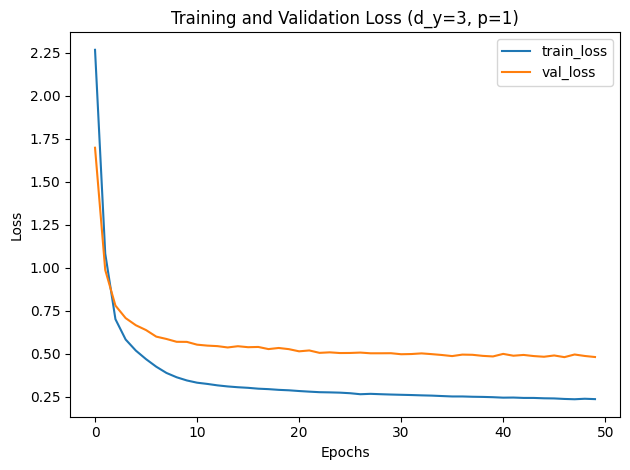

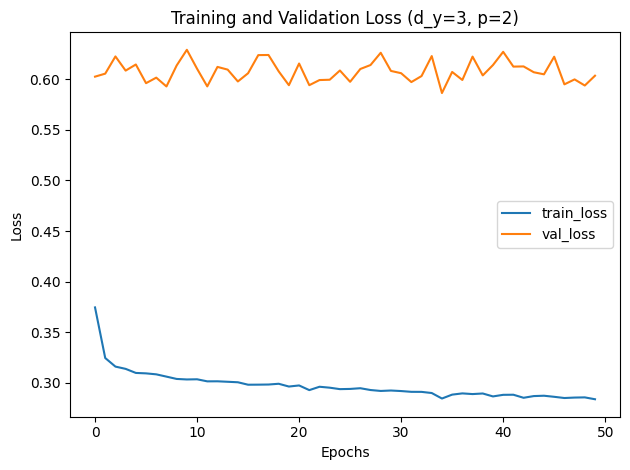

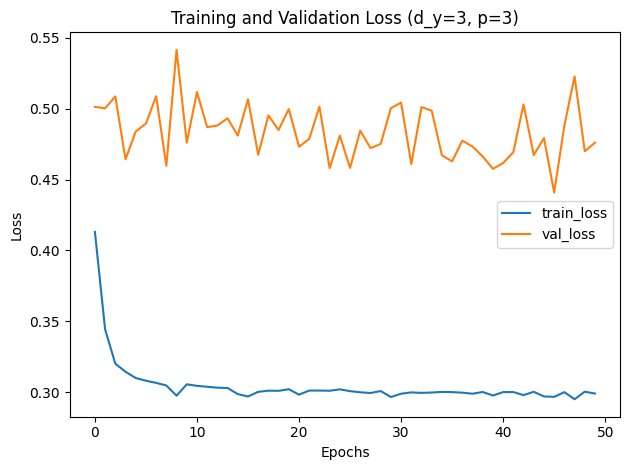

In [219]:
# Testing our functions
model_layers = [
    layers.GRU(activation='relu', units=10),
    layers.Dense(activation='linear', units=1),
]

results_gru = experiments_rnn(data, model_layers)
plot_mse_table(results_gru)
plot_train_val_loss(results_gru)

## Comparison of results and Conclusion

Compare the performance of the models based on the experiment results and make a conclusion

In [222]:
def plot_combined_loss_curves(results):
    plt.figure(figsize=(10, 6))
    
    # Line styles for differentiation between models
    models = ['Regular', 'RNN', 'LSTM', 'GRU']
    line_styles = ['-', '--', '-.']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i in range(len(results)):
        train_losses = results[i][3,3]['history']['loss']
        val_losses = results[i][3,3]['history']['val_loss']
        epochs = range(1, len(train_losses) + 1)
        
        ls = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
        
        plt.plot(epochs, train_losses, label=f'{models[i]} Train', linestyle=ls, color=color)
        plt.plot(epochs, val_losses, label=f'{models[i]} Validation', linestyle=ls, color=color, alpha=0.7)
    
    plt.title('Comparison of Model Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


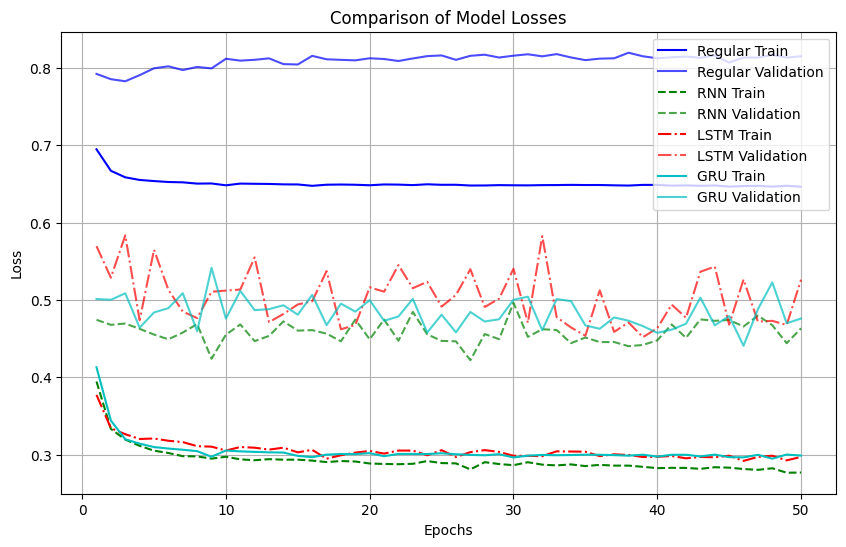

In [225]:
plot_combined_loss_curves([results, results_rnn, results_lstm, results_gru])